In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchdiffeq import odeint_adjoint as odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class ODEFUnc(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, 64),
            nn.Tanh(),
            nn.Linear(64, dim)
        )
    
    def forward(self, t, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        t_expanded = t.expand(x.size(0), 1)  # shape (batch_size, 1)
        tx = torch.cat([x, t_expanded], dim=1)  # shape (batch_size, dim + 1)
        
        return self.net(tx)

class ODEBlock(nn.Module):
    def __init__(self, odefunc):
        super().__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0., 1.]).float()

    def forward(self, x):
        self.integration_time = self.integration_time.to(x.device)
        out = odeint(self.odefunc, x, self.integration_time, method='dopri5')
        return out[-1]

In [3]:
class NeuralODEClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.odeblock = ODEBlock(ODEFUnc(64))
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.odeblock(x)
        x = self.fc2(x)
        return x

In [4]:
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}: Train Loss = {total_loss / len(train_loader):.4f}")

def test(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    print(f"Test Accuracy: {correct / len(test_loader.dataset) * 100:.2f}%")

In [5]:
transform = transforms.ToTensor()
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./data', train=False, transform=transform)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=1000, shuffle=False, pin_memory=True)

In [6]:
model = NeuralODEClassifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, 6):
    train(model, train_loader, optimizer, criterion, epoch)
    test(model, test_loader)

Epoch 1: Train Loss = 0.3856
Test Accuracy: 94.59%
Epoch 2: Train Loss = 0.1616
Test Accuracy: 95.49%
Epoch 3: Train Loss = 0.1188
Test Accuracy: 96.42%
Epoch 4: Train Loss = 0.0945
Test Accuracy: 97.00%
Epoch 5: Train Loss = 0.0795
Test Accuracy: 96.99%


GT = 4, pred = 4


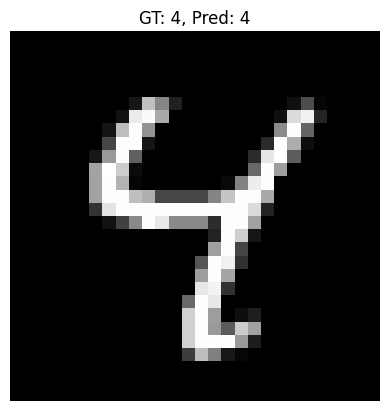

In [29]:
import matplotlib.pyplot as plt

i = 6

data, target = next(iter(test_loader))
data, target = data.to(device), target.to(device)

with torch.no_grad():
    output = model(data)
    pred = output.argmax(dim=1)

print(f"GT = {target[i].item()}, pred = {pred[i].item()}")

img = data[i].cpu().squeeze()
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title(f"GT: {target[i].item()}, Pred: {pred[i].item()}")
plt.show()
